## Importing the libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Importing the dataset

In [2]:
df= pd.read_csv("C:\\Users\\Sarrang\\FindDefault\\transformed_data.csv")
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

## Splitting the dataset into the Training set and Test set

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [30]:
len(df)

284807

In [31]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(random_state=42)
X_train_resampled,y_train_resampled=smote.fit_resample(X_train,y_train)

In [32]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

lgbm = LGBMClassifier()

param_grid = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, scoring='precision', verbose=1, n_jobs=-1)

grid_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Info] Number of positive: 227454, number of negative: 227454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'n_estimators': 100, 'num_leaves': 40, 'subsample': 0.8}


In [33]:
classifier=LGBMClassifier(colsample_bytree=1.0,
                          learning_rate=0.2, 
                          n_estimators=100,
                          num_leaves=40,
                          subsample=0.8)
classifier.fit(X_train_resampled,y_train_resampled)

[LightGBM] [Info] Number of positive: 227454, number of negative: 227454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(learning_rate=0.2, num_leaves=40, subsample=0.8)

In [34]:
y_pred=classifier.predict(X_test)

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56854
           1       0.84      0.79      0.81       108

    accuracy                           1.00     56962
   macro avg       0.92      0.89      0.91     56962
weighted avg       1.00      1.00      1.00     56962



In [36]:
import joblib
joblib.dump(classifier, 'lightgbm_smote_FD.joblib')

['lightgbm_smote_FD.joblib']

C:\Users\Sarrang\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.4.1.post1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[[56838    16]
 [   23    85]]


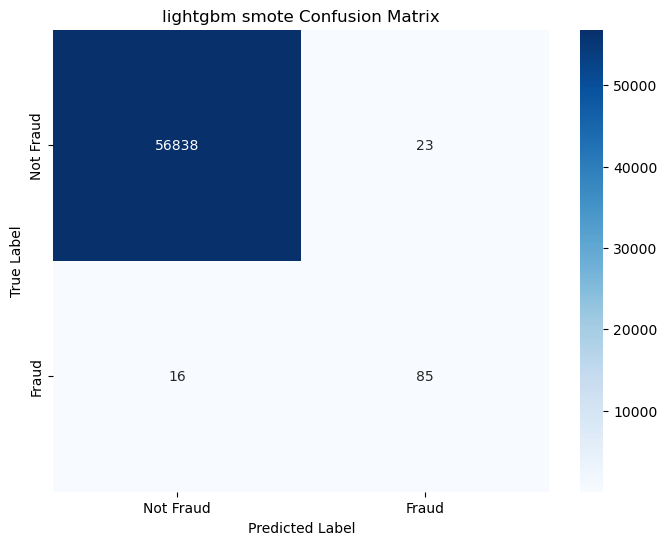

In [6]:
from joblib import load
clf=load("C:\\Users\\Sarrang\\FindDefault\\saved models\\lightgbm_smote_FD.joblib")
y_pred=clf.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_pred,y_test))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('lightgbm smote Confusion Matrix')
plt.show()


In [37]:
from sklearn.metrics import roc_auc_score
y_pred_proba = classifier.predict_proba(X_test)
y_pred_proba_positive = y_pred_proba[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_positive)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.963512202154951


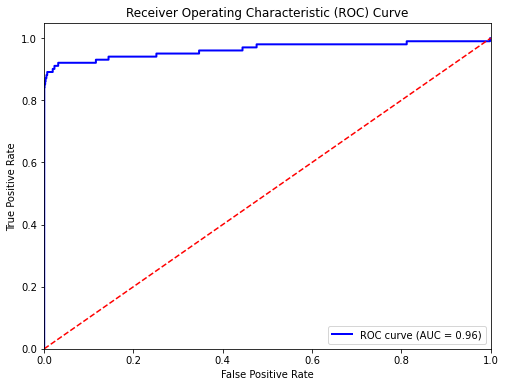

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_positive)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

feature importance

In [39]:
import numpy as np

# Extract feature importances
feature_importances = classifier.feature_importances_

# Get feature names
feature_names = df.columns

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], feature_importances[indices[f]]))

Feature ranking:
1. feature V14 (204.000000)
2. feature V1 (187.000000)
3. feature Amount (179.000000)
4. feature V4 (172.000000)
5. feature V25 (167.000000)
6. feature V24 (166.000000)
7. feature V18 (158.000000)
8. feature Time (157.000000)
9. feature V11 (155.000000)
10. feature V26 (146.000000)
11. feature V3 (145.000000)
12. feature V16 (144.000000)
13. feature V12 (141.000000)
14. feature V5 (126.000000)
15. feature V20 (119.000000)
16. feature V17 (116.000000)
17. feature V8 (114.000000)
18. feature V15 (111.000000)
19. feature V21 (111.000000)
20. feature V7 (109.000000)
21. feature V19 (108.000000)
22. feature V22 (107.000000)
23. feature V27 (105.000000)
24. feature V2 (105.000000)
25. feature V13 (104.000000)
26. feature V28 (102.000000)
27. feature V10 (99.000000)
28. feature V9 (83.000000)
29. feature V6 (81.000000)
30. feature V23 (79.000000)
